In [55]:
%load_ext autoreload
%autoreload 2

import sys
sys.dont_write_bytecode = True

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
#imports
import os
import yaml
import json

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from matplotlib.finance import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from callables import parse_json
from callables import process_data
from callables import generate_features
from callables import select_features

from utils import plot_roc_curve
from utils import find_max_fscore 
from utils import plot_confusion_matrix
from utils import plot_feature_importnaces
from utils import plot_candletick_anomaly

ModuleNotFoundError: No module named 'matplotlib.finance'

In [3]:
#params

filepath_input = '/Users/cotangentofzero/Data_science/trading_project/data/raw_data/'

shift_b = 18
shift_f = 7
anomaly_crtiretion = 1.0050

cb_params = {
    'iterations': 300,
    'learning_rate': 0.03,
    'depth': 5,
    'l2_leaf_reg': 2,
    'rsm': 0.7,
    'verbose': False,
    'allow_writing_files': False,
    'random_state': 42
}

In [44]:
#training sample
df = parse_json(filepath_input)
df = process_data(df)
df = generate_features(df,shift_b,shift_f,anomaly_crtiretion)
df_event,df_model = select_features(df)

In [45]:
#split
train, test = train_test_split(df_model, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

#plot_find_max_fscore
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

#calculate metrics
f_score_train = round(100*f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary'),2)
f_score_test  = round(100*f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary'),2)

metrics_df = pd.DataFrame({'f_score_train':[f_score_train],
                           'f_score_test':[f_score_test]})

display(metrics_df)

,f_score_train,f_score_test
0,19.73,9.75


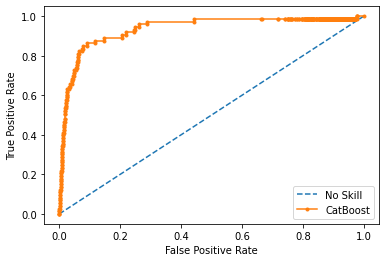

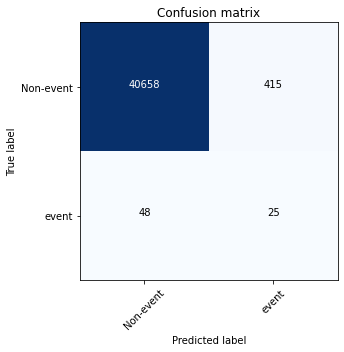

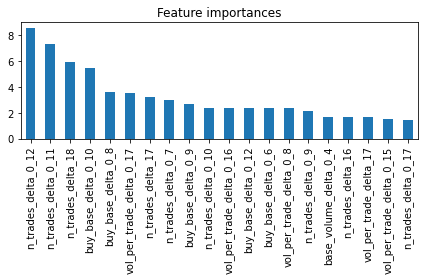

In [46]:
# plot roc curve
plot_roc_curve(y_test, y_test_pred_proba)

#plot_confusion_matrix
plot_confusion_matrix(y_test, y_test_pred_proba, opt_cutoff)

#plot_feature_importances
plot_feature_importnaces(model,x_train, top = 20)

### Test

In [47]:
df_check = df_event[test.index[0]:]
df_check = df_check.drop('target', axis = 1)
df_check['true'] = y_test
df_check['predicted'] = (y_test_pred_proba  > opt_cutoff).astype(int)

#plot_candletick_anomaly(df_check)

### Train

In [31]:
df_check = df_event[train.index[0]:]
df_check = df_check.drop('target', axis = 1)

In [45]:
df_check = df_event[:train.index[-1]+1]
df_check = df_check.drop('target', axis = 1)

df_check['true'] = y_train
df_check['predicted'] = y_train_pred_proba  > opt_cutoff

#plot_candletick_anomaly(df_check)